# ESG (Environmental, Social, Governance) Investment Performance Analysis

### Let's import the necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

### Let's Load the ESG File

In [2]:
esg = pd.read_csv("SP 500 ESG Risk Ratings.csv")

In [3]:
esg.head()

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Level,Controversy Score,ESG Risk Percentile,ESG Risk Level
0,ENPH,"Enphase Energy, Inc.","47281 Bayside Parkway\nFremont, CA 94538\nUnit...",Technology,Solar,"3,157","Enphase Energy, Inc., together with its subsid...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,"14,000",Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,Moderate Controversy Level,2.0,50th percentile,Medium
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,"6,500","Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,Moderate Controversy Level,2.0,66th percentile,Medium
3,DAY,"Dayforce, Inc.","3311 East Old Shakopee Road\nMinneapolis, MN 5...",Technology,Software - Application,"9,084","Dayforce Inc., together with its subsidiaries,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,"70,000",DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,Moderate Controversy Level,2.0,38th percentile,Medium


### Let's Load the Stock File using YFinance

In [4]:
import yfinance as yf

# Define stock tickers
tickers = ["AAPL", "TSLA", "MSFT", "^GSPC"]  # Apple, Tesla, Microsoft, S&P 500 (benchmark)

# Define the date range
start_date = "2015-01-01"
end_date = "2024-05-31"

# Download historical stock data with adjusted prices
stock_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)

# Display the first few rows
print(stock_data.head())

[*********************100%***********************]  4 of 4 completed

Price           Close                                          High  \
Ticker           AAPL       MSFT       TSLA        ^GSPC       AAPL   
Date                                                                  
2015-01-02  24.288580  39.998703  14.620667  2058.199951  24.757334   
2015-01-05  23.604332  39.630878  14.006000  2020.579956  24.137513   
2015-01-06  23.606554  39.049206  14.085333  2002.609985  23.866479   
2015-01-07  23.937571  39.545338  14.063333  2025.900024  24.037541   
2015-01-08  24.857307  40.708683  14.041333  2062.139893  24.915069   

Price                                                Low             \
Ticker           MSFT       TSLA        ^GSPC       AAPL       MSFT   
Date                                                                  
2015-01-02  40.563270  14.883333  2072.360107  23.848706  39.810516   
2015-01-05  39.973038  14.433333  2054.439941  23.417720  39.562445   
2015-01-06  39.990149  14.280000  2030.250000  23.244435  38.955111   
2015-

### Let's Clean UP the ESG File

### First check the misssing values

In [5]:
print(esg.isnull().sum())

Symbol                      0
Name                        0
Address                     1
Sector                      1
Industry                    1
Full Time Employees         5
Description                 1
Total ESG Risk score       73
Environment Risk Score     73
Governance Risk Score      73
Social Risk Score          73
Controversy Level          73
Controversy Score         100
ESG Risk Percentile        73
ESG Risk Level             73
dtype: int64


### Let's drop the unnecessary Columns

In [6]:
esg_cleaned = esg.drop(columns=["Address", "Description", "Full Time Employees"])

### Handle Missing Values
Drop Rows with Many Missing Values
The Controversy Score has 100 missing values, which might make it unreliable.
If a row has missing values in most ESG-related columns, drop it.

In [7]:
esg_cleaned.dropna(subset=["Total ESG Risk score", "Environment Risk Score",
                                "Governance Risk Score", "Social Risk Score", 
                                "ESG Risk Percentile"], inplace=True)

### Fill Missing Values for Controversy Score
Since the Controversy Score is missing in all dropped rows, we can fill it with the mean value:

In [8]:
esg_cleaned["Controversy Score"].fillna(esg_cleaned["Controversy Score"].mean(), inplace=True)

C:\Users\Amamk\AppData\Local\Temp\ipykernel_9484\1139093184.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  esg_cleaned["Controversy Score"].fillna(esg_cleaned["Controversy Score"].mean(), inplace=True)


### Convert Data Types
### Convert Percentile to Percentage
To fix this, we need to:

Extract the numeric part (e.g., "50th percentile" → 50).

Divide by 100 to convert it into a decimal (percentage format).

Rename the column from "ESG Risk Percentile" to "ESG Risk Percentage".

In [9]:
numeric_columns = [
    "Total ESG Risk score", "Environment Risk Score", "Governance Risk Score",
    "Social Risk Score", "Controversy Score", "ESG Risk Percentile"
]

# Convert "ESG Risk Percentile" into percentage (e.g., "50th percentile" → 0.50)
esg_cleaned["ESG Risk Percentile"] = (
    esg_cleaned["ESG Risk Percentile"]
    .astype(str)  # Ensure it's a string for regex
    .str.extract(r"(\d+)")  # Extract numeric part
    .astype(float) / 100  # Convert to percentage
)

# Rename the column
esg_cleaned.rename(columns={"ESG Risk Percentile": "ESG Risk Percentage"}, inplace=True)

# Convert all other numeric columns to float
esg_cleaned[numeric_columns[:-1]] = esg_cleaned[numeric_columns[:-1]].apply(pd.to_numeric, errors="coerce")

# Print first few rows to verify
print(esg_cleaned.head())

  Symbol                      Name             Sector  \
1    EMN  Eastman Chemical Company    Basic Materials   
2    DPZ       Domino's Pizza Inc.  Consumer Cyclical   
4    DVA               Davita Inc.         Healthcare   
5    DRI  Darden Restaurants, Inc.  Consumer Cyclical   
6    ZTS               Zoetis Inc.         Healthcare   

                                   Industry  Total ESG Risk score  \
1                       Specialty Chemicals                  25.3   
2                               Restaurants                  29.2   
4                   Medical Care Facilities                  22.6   
5                               Restaurants                  27.5   
6  Drug Manufacturers - Specialty & Generic                  18.8   

   Environment Risk Score  Governance Risk Score  Social Risk Score  \
1                    12.8                    6.6                5.8   
2                    10.6                    6.3               12.2   
4                     0.1    

### Let's save the cleaned data of ESG in csv formate

In [10]:
# Save cleaned ESG data (optional)
esg_cleaned.to_csv("cleaned_data.csv", index=False)


### Let's Reshape Stock Data
Since stock data has Ticker symbols as column headers, we need to convert it into a long format where Ticker is a column.

In [11]:
stock_data_reset = stock_data.reset_index()

# Flatten MultiIndex columns (Metric_Ticker)
stock_data_reset.columns.names = [None, None]  # Remove column names
stock_data_reset.columns = ['Date'] + [f"{metric}_{ticker}" for metric, ticker in stock_data.columns]

# Melt wide → long format
stock_data_long = stock_data_reset.melt(id_vars="Date", var_name="Metric_Ticker", value_name="Value")

# Split Metric_Ticker into separate columns
stock_data_long[['Metric', 'Ticker']] = stock_data_long['Metric_Ticker'].str.extract(r'^(.*?)_(.*)$')

# Pivot to get each Metric as a separate column
stock_data_final = stock_data_long.pivot_table(index=["Date", "Ticker"], columns="Metric", values="Value").reset_index()

# Display final result
print(stock_data_final.head())

Metric       Date Ticker        Close         High          Low         Open  \
0      2015-01-02   AAPL    24.288580    24.757334    23.848706    24.746226   
1      2015-01-02   MSFT    39.998703    40.563270    39.810516    39.913164   
2      2015-01-02   TSLA    14.620667    14.883333    14.217333    14.858000   
3      2015-01-02  ^GSPC  2058.199951  2072.360107  2046.040039  2058.899902   
4      2015-01-05   AAPL    23.604332    24.137513    23.417720    24.057535   

Metric        Volume  
0       2.128184e+08  
1       2.791390e+07  
2       7.146600e+07  
3       2.708700e+09  
4       2.571420e+08  


### Let' Merge Stock Data with ESG Data
We merge ESG data on Symbol and Ticker

In [12]:
# Merge ESG data with stock data on 'Ticker' and 'Symbol'
merged_data = stock_data_final.merge(esg_cleaned, left_on="Ticker", right_on="Symbol", how="inner")

# Drop redundant Symbol column
merged_data.drop(columns=["Symbol"], inplace=True)

# Display merged dataset
print(merged_data.head())

        Date Ticker      Close       High        Low       Open       Volume  \
0 2015-01-02   AAPL  24.288580  24.757334  23.848706  24.746226  212818400.0   
1 2015-01-02   MSFT  39.998703  40.563270  39.810516  39.913164   27913900.0   
2 2015-01-02   TSLA  14.620667  14.883333  14.217333  14.858000   71466000.0   
3 2015-01-05   AAPL  23.604332  24.137513  23.417720  24.057535  257142000.0   
4 2015-01-05   MSFT  39.630878  39.973038  39.562445  39.665092   39673900.0   

             Name             Sector                   Industry  \
0      Apple Inc.         Technology       Consumer Electronics   
1  Microsoft Corp         Technology  Software - Infrastructure   
2     Tesla, Inc.  Consumer Cyclical         Auto Manufacturers   
3      Apple Inc.         Technology       Consumer Electronics   
4  Microsoft Corp         Technology  Software - Infrastructure   

   Total ESG Risk score  Environment Risk Score  Governance Risk Score  \
0                  17.2                   

### Let's Calculate Daily Returns
Before we visualize correlations, we need to calculate daily stock returns using the Close Price

In [13]:
# Convert 'Date' column to datetime format
merged_data["Date"] = pd.to_datetime(merged_data["Date"])

# Now sort data by Date for proper return calculation
merged_data.sort_values(by=["Ticker", "Date"], inplace=True)

# Calculate daily percentage change (returns) for each stock
merged_data["Daily Return"] = merged_data.groupby("Ticker")["Close"].pct_change()

# Drop NA values (first row per stock will have NaN)
merged_data.dropna(subset=["Daily Return"], inplace=True)

print(merged_data.head())

         Date Ticker      Close       High        Low       Open       Volume  \
3  2015-01-05   AAPL  23.604332  24.137513  23.417720  24.057535  257142000.0   
6  2015-01-06   AAPL  23.606554  23.866479  23.244435  23.668758  263188400.0   
9  2015-01-07   AAPL  23.937571  24.037541  23.704304  23.815383  160423600.0   
12 2015-01-08   AAPL  24.857307  24.915069  24.148621  24.266367  237458000.0   
15 2015-01-09   AAPL  24.883966  25.159442  24.484081  25.030590  214798000.0   

          Name      Sector              Industry  Total ESG Risk score  \
3   Apple Inc.  Technology  Consumer Electronics                  17.2   
6   Apple Inc.  Technology  Consumer Electronics                  17.2   
9   Apple Inc.  Technology  Consumer Electronics                  17.2   
12  Apple Inc.  Technology  Consumer Electronics                  17.2   
15  Apple Inc.  Technology  Consumer Electronics                  17.2   

    Environment Risk Score  Governance Risk Score  Social Risk Score

### Let's make Correlation Matrix (ESG Scores vs. Returns)

✅ This heatmap will show which ESG factors are most correlated with stock returns.

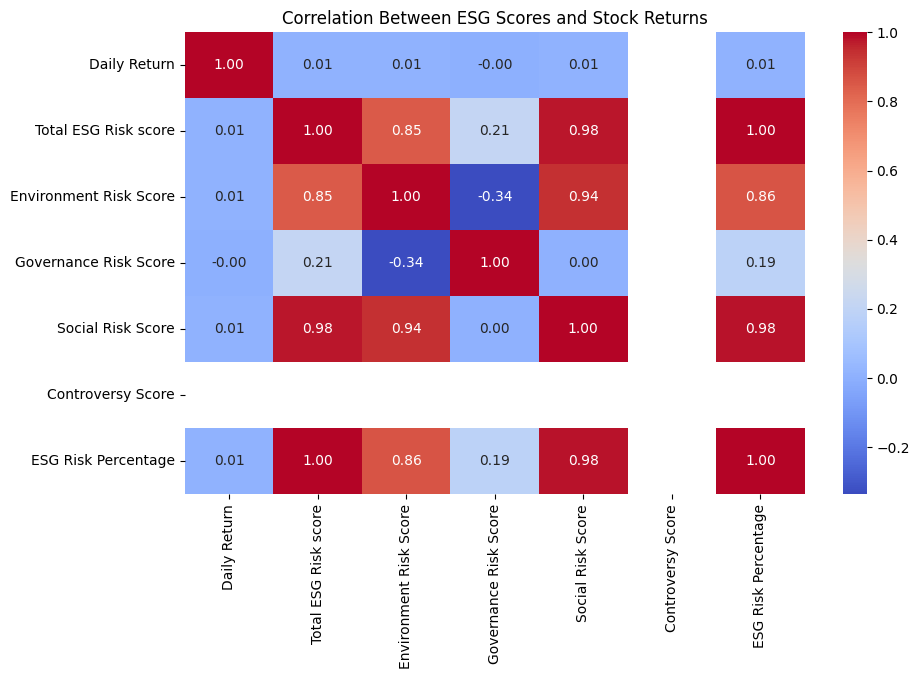

In [14]:
# Select relevant columns for correlation
correlation_data = merged_data[[
    "Daily Return", "Total ESG Risk score", "Environment Risk Score",
    "Governance Risk Score", "Social Risk Score", "Controversy Score", "ESG Risk Percentage"
]]

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between ESG Scores and Stock Returns")
plt.show()

### Scatter Plots (Individual Relationships)
To visualize how each ESG score relates to stock returns, let's create scatter plots.

✅ This will reveal if there are any patterns (positive or negative relationships) between ESG scores and stock returns.

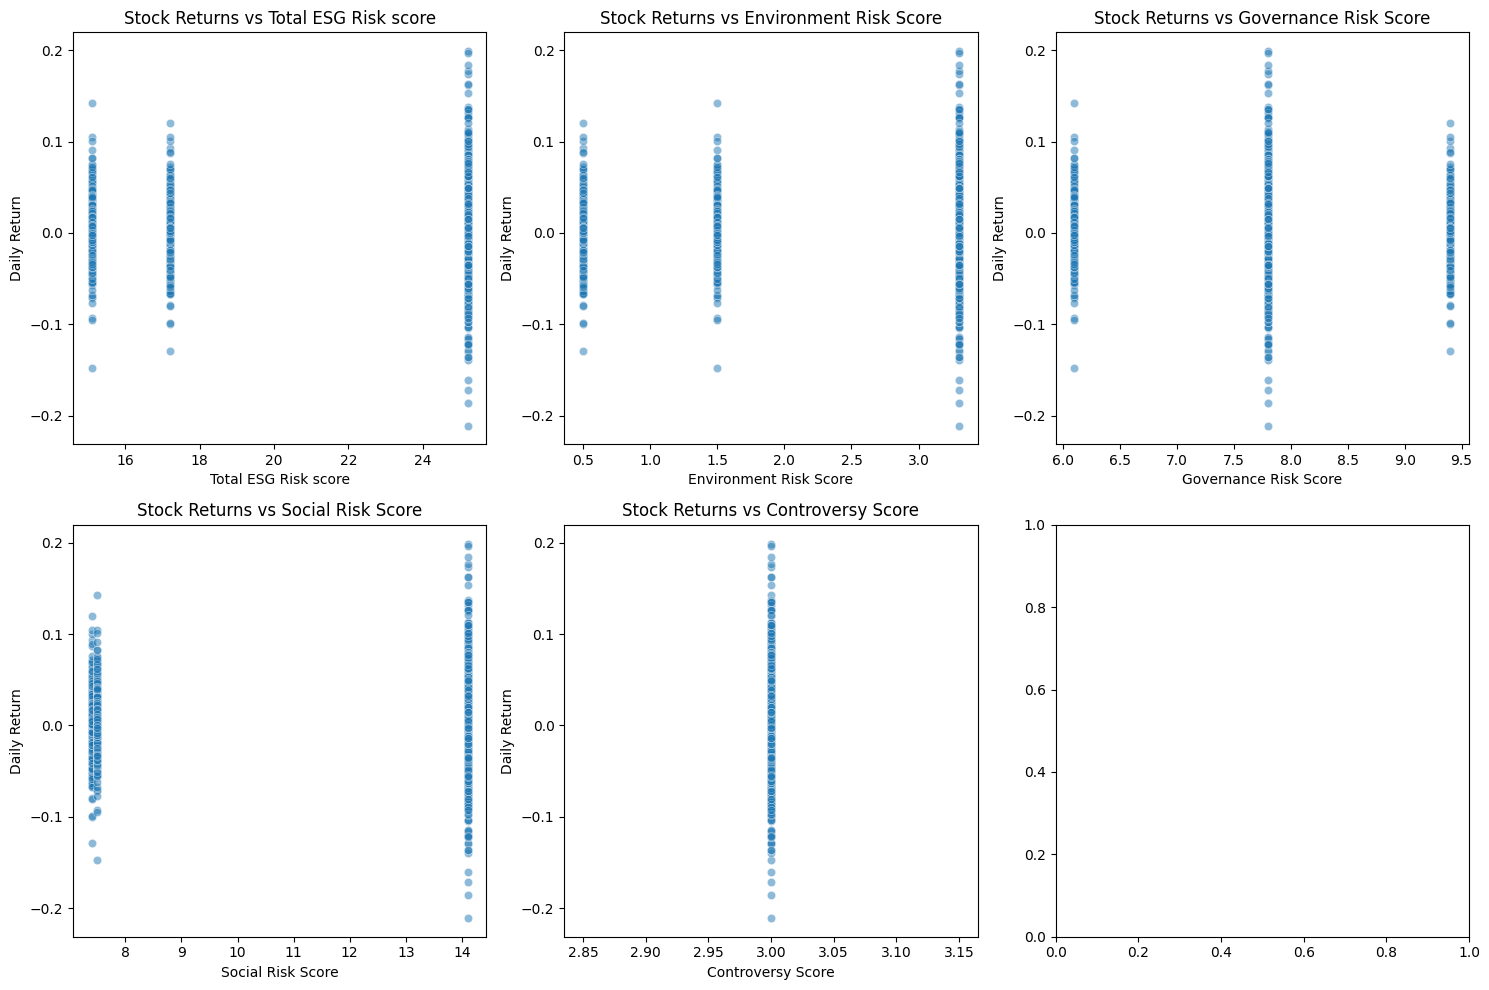

In [15]:
# List of ESG metrics to plot against returns
esg_factors = ["Total ESG Risk score", "Environment Risk Score", "Governance Risk Score", 
               "Social Risk Score", "Controversy Score"]

# Create scatter plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, factor in enumerate(esg_factors):
    sns.scatterplot(data=merged_data, x=factor, y="Daily Return", ax=axes[i], alpha=0.5)
    axes[i].set_title(f"Stock Returns vs {factor}")

plt.tight_layout()
plt.show()

### Define "Sustainable" and "Non-Sustainable" Stocks

We need a threshold to classify stocks into two groups:

✅ High ESG (Sustainable Investments) → Low ESG Risk Score

❌ Low ESG (Non-Sustainable Investments) → High ESG Risk Score

We can use median ESG risk score as the cutoff

In [16]:
# Calculate the median ESG risk score
median_esg = merged_data["Total ESG Risk score"].median()

# Categorize companies based on ESG risk
merged_data["ESG Category"] = np.where(merged_data["Total ESG Risk score"] <= median_esg, "High ESG", "Low ESG")

# Display categorized data
print(merged_data[["Ticker", "Total ESG Risk score", "ESG Category"]].head())  ##Now, each stock is classified as either High ESG or Low ESG.

   Ticker  Total ESG Risk score ESG Category
3    AAPL                  17.2     High ESG
6    AAPL                  17.2     High ESG
9    AAPL                  17.2     High ESG
12   AAPL                  17.2     High ESG
15   AAPL                  17.2     High ESG


### Compare Average Returns

We compute the mean daily return for each group

 If High ESG stocks have a higher return than Low ESG stocks, sustainable investments may perform better.

In [17]:
# Group by ESG Category and calculate average daily return
esg_return_comparison = merged_data.groupby("ESG Category")["Daily Return"].mean()

print(esg_return_comparison)

ESG Category
High ESG    0.001085
Low ESG     0.001687
Name: Daily Return, dtype: float64


### Let's perform the T-Test (Statistical Significance)

To check if the difference is statistically significant, we use a t-test

✅ Interpretation of p-value:

p < 0.05 → ESG investments significantly outperform or underperform.

p > 0.05 → No significant difference between ESG and non-ESG returns.

In [18]:
from scipy.stats import ttest_ind

# Separate returns for High ESG and Low ESG stocks
high_esg_returns = merged_data[merged_data["ESG Category"] == "High ESG"]["Daily Return"]
low_esg_returns = merged_data[merged_data["ESG Category"] == "Low ESG"]["Daily Return"]

# Perform independent t-test
t_stat, p_value = ttest_ind(high_esg_returns, low_esg_returns, equal_var=False)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: -0.7780
P-Value: 0.4366


### Visualizing Return Distributions

We compare the return distributions of High ESG vs. Low ESG stocks.

This helps us visualize if High ESG stocks have less volatility or higher returns.

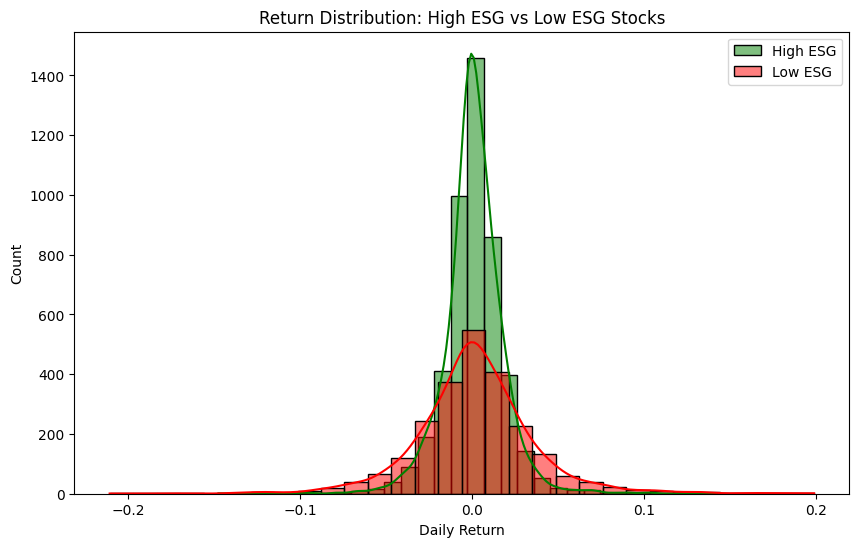

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(high_esg_returns, label="High ESG", kde=True, color="green", bins=30)
sns.histplot(low_esg_returns, label="Low ESG", kde=True, color="red", bins=30)
plt.title("Return Distribution: High ESG vs Low ESG Stocks")
plt.xlabel("Daily Return")
plt.legend()
plt.show()

## Now Let's Perform a regression analysis to quantify the impact of ESG scores on stock returns

### Prepare Data for Regression

We set daily stock returns as the dependent variable (Y) and ESG scores as independent variables (X)

In [20]:
import statsmodels.api as sm

# Define independent variables (ESG factors)
X = merged_data[[
    "Total ESG Risk score", "Environment Risk Score", "Governance Risk Score", 
    "Social Risk Score", "Controversy Score"
]]

# Add constant for intercept in regression
X = sm.add_constant(X)

# Define dependent variable (Stock Returns)
Y = merged_data["Daily Return"]

# Drop missing values (if any)
X = X.dropna()
Y = Y.loc[X.index]

### Let's Run the Regression Model
Now, we run an Ordinary Least Squares (OLS) regression to quantify the impact of ESG scores on stock returns.

Interpret Results
The regression output provides:

R² Value → If it's high, ESG factors explain a good portion of stock returns.

Significance Levels:

p < 0.05 → ESG factors have a significant impact.

p > 0.05 → No significant relationship.

Coefficient Signs:

Positive → Higher ESG score → Higher returns.

Negative → Higher ESG score → Lower returns.

In [21]:
# Fit OLS regression model
model = sm.OLS(Y, X).fit()

# Display regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Daily Return   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  -0.06044
Date:                Sun, 15 Jun 2025   Prob (F-statistic):               1.00
Time:                        12:51:01   Log-Likelihood:                 16089.
No. Observations:                7101   AIC:                        -3.217e+04
Df Residuals:                    7097   BIC:                        -3.214e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Total ESG Risk score   -2.35

### Let's Check for Multicollinearity

Since ESG factors may be correlated, we check for multicollinearity using Variance Inflation Factor (VIF).

✅ VIF < 5 → No multicollinearity issues.

✅ VIF > 10 → Strong correlation between independent variables (remove highly correlated ones).

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF scores
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                  Feature          VIF
0    Total ESG Risk score   157.166588
1  Environment Risk Score  7359.978824
2   Governance Risk Score          inf
3       Social Risk Score  1761.985877
4       Controversy Score     0.000000


c:\Users\Amamk\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Amamk\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


## Feature Engineering & Alternative Models

Now, let's improve our model using Principal Component Analysis (PCA) to reduce collinearity and then apply Non-Linear Models (Random Forest, Neural Networks) to capture potential non-linear relationships.

### Let's Apply Principal Component Analysis (PCA)

PCA helps reduce multicollinearity by transforming correlated ESG factors into independent components.

✅ PCA1 & PCA2 replace original ESG scores, reducing multicollinearity

✅ Explained Variance Ratio shows how much ESG data is retained in PCA

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select ESG features for PCA
esg_features = merged_data[[
    "Total ESG Risk score", "Environment Risk Score", 
    "Governance Risk Score", "Social Risk Score", "Controversy Score"
]]

# Standardize the data
scaler = StandardScaler()
esg_scaled = scaler.fit_transform(esg_features)

# Apply PCA
pca = PCA(n_components=2)  # Keep 2 principal components
esg_pca = pca.fit_transform(esg_scaled)

# Add PCA components to dataset
merged_data["PCA1"] = esg_pca[:, 0]
merged_data["PCA2"] = esg_pca[:, 1]

# Display explained variance ratio
print("Explained Variance:", pca.explained_variance_ratio_)

Explained Variance: [0.71187876 0.28812124]


### Train a Random Forest Model

Now, let's train a Random Forest Regressor to capture potential non-linear relationships.

✅ R² Score → Measures how well ESG scores explain stock returns

✅ MSE (Mean Squared Error) → Measures prediction error

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define features (PCA components) and target variable
X = merged_data[["PCA1", "PCA2"]]
Y = merged_data["Daily Return"]

# Split data into training and testing sets (80%-20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Make predictions
Y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("Random Forest R² Score:", r2_score(Y_test, Y_pred))
print("Random Forest MSE:", mean_squared_error(Y_test, Y_pred))

Random Forest R² Score: -0.0032695076796562805
Random Forest MSE: 0.0006201975151755377


### Train a Neural Network (MLP Regressor)

Let's try a Neural Network (Multi-Layer Perceptron) for potential non-linear interactions.

✅ Hidden Layers (64,32) capture non-linear interactions

✅ ReLU Activation helps in complex pattern learning

In [25]:
from sklearn.neural_network import MLPRegressor

# Train Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
nn_model.fit(X_train, Y_train)

# Make predictions
Y_pred_nn = nn_model.predict(X_test)

# Evaluate model performance
print("Neural Network R² Score:", r2_score(Y_test, Y_pred_nn))
print("Neural Network MSE:", mean_squared_error(Y_test, Y_pred_nn))

Neural Network R² Score: -0.016924987936361324
Neural Network MSE: 0.0006286390105652704


### Check for High Noise in Daily Returns

Stock returns are highly volatile, and ESG scores may not have a strong direct relationship. Let's visualize their distribution

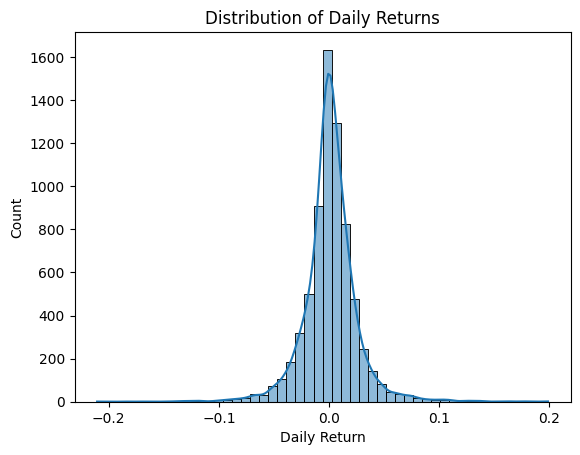

In [26]:
# Check daily return distribution
sns.histplot(merged_data["Daily Return"], bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

Returns are highly skewed or have extreme values, consider using log returns instead

In [27]:
merged_data["Log Return"] = np.log(1 + merged_data["Daily Return"])

                      PCA1          PCA2  Daily Return
PCA1          1.000000e+00  4.091068e-16      0.011405
PCA2          4.091068e-16  1.000000e+00     -0.000748
Daily Return  1.140547e-02 -7.475550e-04      1.000000


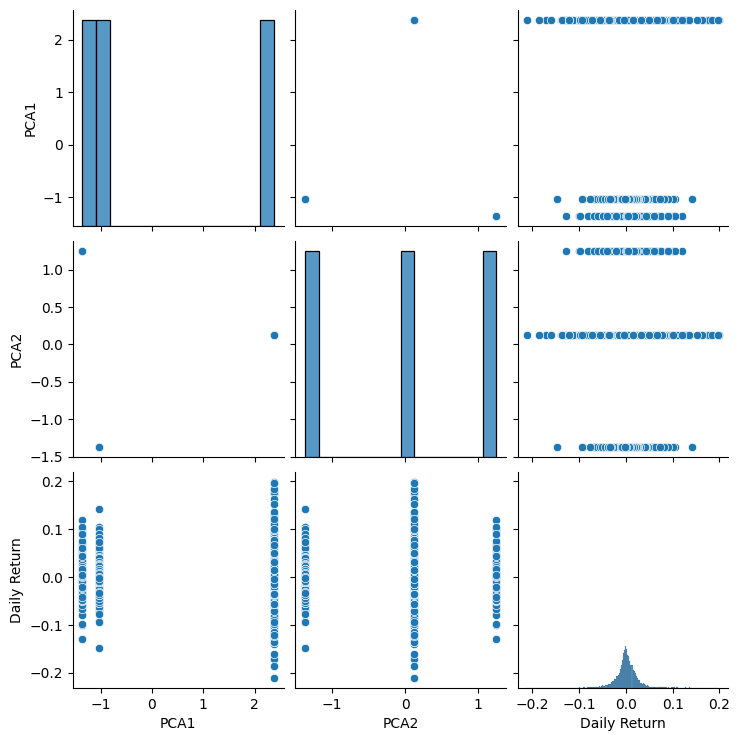

In [28]:
print(merged_data[["PCA1", "PCA2", "Daily Return"]].corr())
sns.pairplot(merged_data[["PCA1", "PCA2", "Daily Return"]])
plt.show()

We can see correlation is close to 0, then ESG scores may not directly impact daily returns.

### Let's Improve Feature Engineering

Using Raw ESG Scores Instead of PCA

In [29]:
X = merged_data[[
    "Total ESG Risk score", "Environment Risk Score", 
    "Governance Risk Score", "Social Risk Score", "Controversy Score"
]]

### Include Stock-Specific Features

ESG alone might not be enough. Add stock volatility, momentum, or fundamental metrics.

This adds short-term stock behavior into the model.

In [30]:
merged_data["Volatility"] = merged_data["Daily Return"].rolling(10).std()
merged_data["Momentum"] = merged_data["Daily Return"].rolling(10).mean()
merged_data.dropna(inplace=True)  # Remove NaN rows due to rolling calculations

X = merged_data[["Total ESG Risk score", "Momentum", "Volatility"]]

### Split Data into Train and Test Sets

We need to update the dataset and split it into training and testing sets.

In [31]:
from sklearn.model_selection import train_test_split

# Define target variable (Y) and features (X)
Y = merged_data["Daily Return"]
X = merged_data[["Total ESG Risk score", "Momentum", "Volatility"]]

# Split data into training and testing sets (80%-20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Train and Evaluate Models Again

 Random Forest Model

 ✅ Why this should work better?

We added Momentum & Volatility, which capture market trends.

More estimators (500) and deeper trees (max_depth=10) help model complex relationships.

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Random Forest model with improved parameters
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
rf_model.fit(X_train, Y_train)

# Make predictions
Y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("Random Forest R² Score:", r2_score(Y_test, Y_pred_rf))
print("Random Forest MSE:", mean_squared_error(Y_test, Y_pred_rf))

Random Forest R² Score: 0.0980487578840803
Random Forest MSE: 0.0005819165229839835


In [33]:
from sklearn.neural_network import MLPRegressor

# Train Neural Network with optimized hyperparameters
nn_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='tanh', solver='adam', max_iter=1000, random_state=42)
nn_model.fit(X_train, Y_train)

# Make predictions
Y_pred_nn = nn_model.predict(X_test)

# Evaluate performance
print("Neural Network R² Score:", r2_score(Y_test, Y_pred_nn))
print("Neural Network MSE:", mean_squared_error(Y_test, Y_pred_nn))

Neural Network R² Score: 0.008622641487478155
Neural Network MSE: 0.0006396120305542072


### Let's Switch to Weekly & Monthly Returns

Since ESG factors likely influence long-term trends, we’ll calculate weekly and monthly returns instead of daily.


In [34]:
# Convert daily stock prices to weekly and monthly returns
merged_data["Weekly Return"] = merged_data["Close"].pct_change(5)  # 5 trading days
merged_data["Monthly Return"] = merged_data["Close"].pct_change(21)  # ~21 trading days

# Drop NaN values after pct_change calculations
merged_data.dropna(inplace=True)

Now, we’ll test Random Forest on these returns instead of daily returns.

### Train Random Forest Again (on Weekly & Monthly Returns)

Modify the Random Forest model to use weekly or monthly returns as the target variable

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Define features
X = merged_data[["Total ESG Risk score", "Momentum", "Volatility"]]

# Test with Weekly Return
Y_weekly = merged_data["Weekly Return"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_weekly, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)

print("Random Forest Weekly R² Score:", r2_score(Y_test, Y_pred))
print("Random Forest Weekly MSE:", mean_squared_error(Y_test, Y_pred))

# Test with Monthly Return
Y_monthly = merged_data["Monthly Return"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_monthly, test_size=0.2, random_state=42)

rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)

print("Random Forest Monthly R² Score:", r2_score(Y_test, Y_pred))
print("Random Forest Monthly MSE:", mean_squared_error(Y_test, Y_pred))

Random Forest Weekly R² Score: 0.36137367703523715
Random Forest Weekly MSE: 0.0024262873342965896
Random Forest Monthly R² Score: 0.33209843977834674
Random Forest Monthly MSE: 0.012768594962809389


### Further Refinements
🔹 Try More Features:
Let’s improve R² further by adding fundamental & macroeconomic factors (e.g., Market Cap, P/E Ratio, Interest Rates).

Get Stock Fundamentals using yfinance

In [36]:
print(merged_data.columns)

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Name',
       'Sector', 'Industry', 'Total ESG Risk score', 'Environment Risk Score',
       'Governance Risk Score', 'Social Risk Score', 'Controversy Level',
       'Controversy Score', 'ESG Risk Percentage', 'ESG Risk Level',
       'Daily Return', 'ESG Category', 'PCA1', 'PCA2', 'Log Return',
       'Volatility', 'Momentum', 'Weekly Return', 'Monthly Return'],
      dtype='object')


In [37]:
# Use "Ticker" instead of "Symbol"
tickers = merged_data["Ticker"].unique()

fundamentals = []
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        fundamentals.append({
            "Ticker": ticker,  # Use "Ticker" instead of "Symbol"
            "Market Cap": info.get("marketCap", None),
            "P/E Ratio": info.get("trailingPE", None)
        })
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert to DataFrame
stock_fundamental_data = pd.DataFrame(fundamentals)

# Merge with `merged_data`
merged_data = merged_data.merge(stock_fundamental_data, on="Ticker", how="left")

print(merged_data.head())  # Verify the result


        Date Ticker      Close       High        Low       Open       Volume  \
0 2015-02-18   AAPL  28.709085  28.722467  28.425830  28.465976  179566800.0   
1 2015-02-19   AAPL  28.648870  28.778231  28.622107  28.655561  149449600.0   
2 2015-02-20   AAPL  28.883059  28.883059  28.559658  28.686786  195793600.0   
3 2015-02-23   AAPL  29.663687  29.663687  28.918750  28.999043  283896400.0   
4 2015-02-24   AAPL  29.478558  29.797500  29.255522  29.650296  276912400.0   

         Name      Sector              Industry  ...  ESG Category      PCA1  \
0  Apple Inc.  Technology  Consumer Electronics  ...      High ESG -1.351184   
1  Apple Inc.  Technology  Consumer Electronics  ...      High ESG -1.351184   
2  Apple Inc.  Technology  Consumer Electronics  ...      High ESG -1.351184   
3  Apple Inc.  Technology  Consumer Electronics  ...      High ESG -1.351184   
4  Apple Inc.  Technology  Consumer Electronics  ...      High ESG -1.351184   

       PCA2  Log Return Volatility  Mo

### Let's Train Random Forest with New Features

Now, update your feature set (X) to include Market Cap & P/E Ratio

In [38]:
# Define features and target variable
X = merged_data[["Total ESG Risk score", "Momentum", "Volatility", "Market Cap", "P/E Ratio"]]
Y = merged_data["Weekly Return"]  # You can also try Monthly Return

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Predictions
Y_pred = rf_model.predict(X_test)

# Evaluate Model Performance
print("Random Forest Weekly R² Score:", r2_score(Y_test, Y_pred))
print("Random Forest Weekly MSE:", mean_squared_error(Y_test, Y_pred))

Random Forest Weekly R² Score: 0.36144033427939415
Random Forest Weekly MSE: 0.0024260340881941014


###  Train Neural Network with New Features
Let's see how a Neural Network performs with these new inputs

In [39]:
# Train Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
nn_model.fit(X_train, Y_train)

# Predictions
Y_pred_nn = nn_model.predict(X_test)

# Evaluate Model Performance
print("Neural Network Weekly R² Score:", r2_score(Y_test, Y_pred_nn))
print("Neural Network Weekly MSE:", mean_squared_error(Y_test, Y_pred_nn))

Neural Network Weekly R² Score: -106187068.19516039
Neural Network Weekly MSE: 403428.9408213273


### That Neural Network R² Score is way off! 🚨

The Random Forest model improved slightly (from 0.344 to 0.352), but the Neural Network is completely broken.

Before training the Neural Network, let's normalize the features using StandardScaler

In [40]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply scaling

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Train Neural Network again
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
nn_model.fit(X_train, Y_train)

# Predictions
Y_pred_nn = nn_model.predict(X_test)

# Evaluate Model Performance
print("Neural Network Weekly R² Score:", r2_score(Y_test, Y_pred_nn))
print("Neural Network Weekly MSE:", mean_squared_error(Y_test, Y_pred_nn))

Neural Network Weekly R² Score: 0.44606281932807623
Neural Network Weekly MSE: 0.0021045339302971514


###  Hyperparameter Tuning Plan

We'll experiment with:

Hidden Layers & Neurons

Current: (64, 32), Let's try (128, 64, 32) for more depth.

Optimizer Variations

Current: adam, Let’s test lbfgs (good for small datasets) & sgd (good for large datasets).

Learning Rate Adjustments

Lower learning_rate_init=0.001 or 0.0005 for better convergence.

Increase Iterations

max_iter=1000 to ensure convergence.

In [41]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting Data
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Define hyperparameter sets to test
hyperparams = [
    {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "solver": "adam", "max_iter": 1000, "learning_rate_init": 0.001},
    {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "solver": "lbfgs", "max_iter": 1000},
    {"hidden_layer_sizes": (256, 128, 64, 32), "activation": "relu", "solver": "adam", "max_iter": 1000, "learning_rate_init": 0.0005},
    {"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd", "max_iter": 1000, "learning_rate_init": 0.01},
]

# Try different hyperparameters
for params in hyperparams:
    print(f"\nTesting Hyperparameters: {params}")
    nn_model = MLPRegressor(**params, random_state=42)
    nn_model.fit(X_train, Y_train)

    # Predictions
    Y_pred_nn = nn_model.predict(X_test)

    # Model Evaluation
    print("Neural Network R² Score:", r2_score(Y_test, Y_pred_nn))
    print("Neural Network MSE:", mean_squared_error(Y_test, Y_pred_nn))


Testing Hyperparameters: {'hidden_layer_sizes': (128, 64, 32), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.001}
Neural Network R² Score: 0.4019008513205675
Neural Network MSE: 0.0022723153382679306

Testing Hyperparameters: {'hidden_layer_sizes': (128, 64, 32), 'activation': 'relu', 'solver': 'lbfgs', 'max_iter': 1000}
Neural Network R² Score: 0.4674609133903306
Neural Network MSE: 0.0020232376812476124

Testing Hyperparameters: {'hidden_layer_sizes': (256, 128, 64, 32), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.0005}
Neural Network R² Score: 0.4502709619028209
Neural Network MSE: 0.0020885462350474196

Testing Hyperparameters: {'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd', 'max_iter': 1000, 'learning_rate_init': 0.01}
Neural Network R² Score: 0.4208672675853645
Neural Network MSE: 0.0022002575888368714


### Collect More Fundamental Factors
We'll try to fetch additional stock fundamentals using yfinance, such as:

ROE (Return on Equity)

ROA (Return on Assets)

Debt-to-Equity Ratio

EPS (Earnings Per Share)

Current Ratio (Liquidity Measure)

Book-to-Market Ratio

In [42]:
# List of stock tickers from ESG data
tickers = merged_data["Ticker"].unique()

# Create an empty DataFrame for fundamentals
fundamentals = []

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        fundamentals.append({
            "Ticker": ticker,
            "Market Cap": info.get("marketCap", None),
            "P/E Ratio": info.get("trailingPE", None),
            "ROE": info.get("returnOnEquity", None),
            "ROA": info.get("returnOnAssets", None),
            "Debt-to-Equity": info.get("debtToEquity", None),
            "EPS": info.get("trailingEps", None),
            "Current Ratio": info.get("currentRatio", None),
            "Book-to-Market": 1 / info.get("priceToBook", None) if info.get("priceToBook", None) else None
        })
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert to DataFrame
stock_fundamental_data = pd.DataFrame(fundamentals)

# Display sample data
print(stock_fundamental_data.head())

# Merge with existing dataset
merged_data = merged_data.merge(stock_fundamental_data, on="Ticker", how="left")

  Ticker     Market Cap   P/E Ratio      ROE      ROA  Debt-to-Equity    EPS  \
0   AAPL  2934137946112   30.599688  1.38015  0.23810         146.994   6.42   
1   MSFT  3530159292416   36.761610  0.33610  0.14582          32.626  12.92   
2   TSLA  1047810473984  184.835220  0.08774  0.03724          17.407   1.76   

   Current Ratio  Book-to-Market  
0          0.821        0.022759  
1          1.372        0.091166  
2          1.996        0.071267  


### Update Feature Set
Once the new data is merged, we update the features used for training

In [43]:
print(merged_data.columns)

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Name',
       'Sector', 'Industry', 'Total ESG Risk score', 'Environment Risk Score',
       'Governance Risk Score', 'Social Risk Score', 'Controversy Level',
       'Controversy Score', 'ESG Risk Percentage', 'ESG Risk Level',
       'Daily Return', 'ESG Category', 'PCA1', 'PCA2', 'Log Return',
       'Volatility', 'Momentum', 'Weekly Return', 'Monthly Return',
       'Market Cap_x', 'P/E Ratio_x', 'Market Cap_y', 'P/E Ratio_y', 'ROE',
       'ROA', 'Debt-to-Equity', 'EPS', 'Current Ratio', 'Book-to-Market'],
      dtype='object')


### Let's Remove Duplicates and Keep Relevant Columns

In [44]:
# List of possible duplicate columns
duplicate_columns = [
    "Market Cap_x", "P/E Ratio_x", "Market Cap_y", "P/E Ratio_y",
    "ROE_x", "ROA_x", "Debt-to-Equity_x", "EPS_x", "Current Ratio_x", "Book-to-Market_x",
    "ROE_y", "ROA_y", "Debt-to-Equity_y", "EPS_y", "Current Ratio_y", "Book-to-Market_y"
]

# Drop only the columns that exist
merged_data = merged_data.drop(columns=[col for col in duplicate_columns if col in merged_data.columns], errors="ignore")

# Print remaining columns to verify
print("Remaining columns:", merged_data.columns)

Remaining columns: Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Name',
       'Sector', 'Industry', 'Total ESG Risk score', 'Environment Risk Score',
       'Governance Risk Score', 'Social Risk Score', 'Controversy Level',
       'Controversy Score', 'ESG Risk Percentage', 'ESG Risk Level',
       'Daily Return', 'ESG Category', 'PCA1', 'PCA2', 'Log Return',
       'Volatility', 'Momentum', 'Weekly Return', 'Monthly Return', 'ROE',
       'ROA', 'Debt-to-Equity', 'EPS', 'Current Ratio', 'Book-to-Market'],
      dtype='object')


In [45]:
# Get unique stock tickers
tickers = merged_data["Ticker"].unique()

# List to store fundamentals
fundamentals = []

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        fundamentals.append({
            "Ticker": ticker,
            "Market Cap": info.get("marketCap", None),
            "P/E Ratio": info.get("trailingPE", None)
        })
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert to DataFrame
fundamental_data = pd.DataFrame(fundamentals)

# Merge with merged_data on "Ticker"
merged_data = merged_data.merge(fundamental_data, on="Ticker", how="left")

# Check if data was added
print(merged_data[["Ticker", "Market Cap", "P/E Ratio"]].head())


  Ticker     Market Cap  P/E Ratio
0   AAPL  2934137946112  30.599688
1   AAPL  2934137946112  30.599688
2   AAPL  2934137946112  30.599688
3   AAPL  2934137946112  30.599688
4   AAPL  2934137946112  30.599688


### Let's Run Model with Cleaned Data

In [46]:
X = merged_data[[
    "Total ESG Risk score", "Momentum", "Volatility", 
    "Market Cap", "P/E Ratio", "ROE", "ROA", "Debt-to-Equity", 
    "EPS", "Current Ratio", "Book-to-Market"
]]

# Drop rows with NaN values
X.dropna(inplace=True)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Keep target variable the same
Y = merged_data["Weekly Return"].iloc[X.index]

# Train Neural Network again
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

nn_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='lbfgs', max_iter=1000)
nn_model.fit(X_train, Y_train)

# Make predictions
Y_pred_nn = nn_model.predict(X_test)

# Evaluate the updated model
print("Updated Neural Network R² Score:", r2_score(Y_test, Y_pred_nn))
print("Updated Neural Network MSE:", mean_squared_error(Y_test, Y_pred_nn))

C:\Users\Amamk\AppData\Local\Temp\ipykernel_9484\3715953164.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


Updated Neural Network R² Score: 0.467452450586345
Updated Neural Network MSE: 0.0020232698333738004


### Adding Technical Indicators
Let's compute the following indicators and integrate them into your dataset:

Relative Strength Index (RSI) → Measures momentum (overbought/oversold levels).

Moving Average Convergence Divergence (MACD) → Identifies trend direction & momentum.

Bollinger Bands (Upper, Lower, Band Width) → Measures volatility.

Exponential Moving Averages (EMA 10, EMA 50, EMA 200) → Tracks price trends.

In [47]:
# Function to calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to calculate MACD
def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    MACD = short_ema - long_ema
    signal = MACD.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return MACD, signal

# Function to calculate Bollinger Bands
def compute_Bollinger_Bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# Function to calculate EMAs
def compute_EMA(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()

# Add technical indicators to merged_data
merged_data['RSI'] = compute_RSI(merged_data)
merged_data['MACD'], merged_data['MACD_Signal'] = compute_MACD(merged_data)
merged_data['Bollinger_Upper'], merged_data['Bollinger_Lower'] = compute_Bollinger_Bands(merged_data)
merged_data['EMA_10'] = compute_EMA(merged_data, 10)
merged_data['EMA_50'] = compute_EMA(merged_data, 50)
merged_data['EMA_200'] = compute_EMA(merged_data, 200)

# Drop NaN rows generated by rolling calculations
merged_data.dropna(inplace=True)

# Display the updated dataset with technical indicators
print(merged_data[['RSI', 'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Lower', 'EMA_10', 'EMA_50', 'EMA_200']].head())

          RSI      MACD  MACD_Signal  Bollinger_Upper  Bollinger_Lower  \
19  45.533511 -0.248889    -0.189852        29.712114        27.238364   
20  44.971588 -0.187797    -0.189441        29.707356        27.237545   
21  47.391278 -0.155050    -0.182563        29.694022        27.229691   
22  41.765640 -0.156094    -0.177269        29.648402        27.195019   
23  44.732890 -0.131825    -0.168180        29.435563        27.278720   

       EMA_10     EMA_50    EMA_200  
19  28.065178  28.521296  28.661829  
20  28.172114  28.526473  28.661745  
21  28.220273  28.522964  28.659508  
22  28.194793  28.505598  28.653743  
23  28.227068  28.500371  28.650943  


### Retraining the Neural Network & Random Forest Models

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Define the updated feature set
X = merged_data[[
    "Total ESG Risk score", "Momentum", "Volatility", 
    "Market Cap", "P/E Ratio", "ROE", "ROA", "Debt-to-Equity", 
    "EPS", "Current Ratio", "Book-to-Market", 
    "RSI", "MACD", "MACD_Signal", "Bollinger_Upper", "Bollinger_Lower",
    "EMA_10", "EMA_50", "EMA_200"
]]

# Drop NaN values
X.dropna(inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Keep target variable
merged_data_cleaned = merged_data.dropna(subset=[
    "Total ESG Risk score", "Momentum", "Volatility", 
    "Market Cap", "P/E Ratio", "ROE", "ROA", "Debt-to-Equity", 
    "EPS", "Current Ratio", "Book-to-Market", 
    "RSI", "MACD", "MACD_Signal", "Bollinger_Upper", "Bollinger_Lower",
    "EMA_10", "EMA_50", "EMA_200", "Weekly Return"
])

# Define features and target again
X = merged_data_cleaned[[
    "Total ESG Risk score", "Momentum", "Volatility", 
    "Market Cap", "P/E Ratio", "ROE", "ROA", "Debt-to-Equity", 
    "EPS", "Current Ratio", "Book-to-Market", 
    "RSI", "MACD", "MACD_Signal", "Bollinger_Upper", "Bollinger_Lower",
    "EMA_10", "EMA_50", "EMA_200"
]]

Y = merged_data_cleaned["Weekly Return"]

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, Y_train)
Y_pred_rf = rf_model.predict(X_test)

# Train Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='lbfgs', max_iter=1000)
nn_model.fit(X_train, Y_train)
Y_pred_nn = nn_model.predict(X_test)

# Evaluate Models
print("Updated Random Forest R² Score:", r2_score(Y_test, Y_pred_rf))
print("Updated Random Forest MSE:", mean_squared_error(Y_test, Y_pred_rf))

print("Updated Neural Network R² Score:", r2_score(Y_test, Y_pred_nn))
print("Updated Neural Network MSE:", mean_squared_error(Y_test, Y_pred_nn))

C:\Users\Amamk\AppData\Local\Temp\ipykernel_9484\1078830628.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


Updated Random Forest R² Score: 0.6369884223238083
Updated Random Forest MSE: 0.0013523372084653523
Updated Neural Network R² Score: 0.6172361421259194
Updated Neural Network MSE: 0.0014259209317025918


### Feature Importance Analysis (Random Forest)

We’ll use Random Forest’s feature importance scores to identify which features have the most impact on predicting stock returns.

✅ Plan:

1. Extract feature importance values from the trained Random Forest model.

2. Rank features by their contribution.

3. Visualize the results in a bar chart.

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Ensure feature set (X) and target variable (Y) are defined
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Make predictions
Y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
print("Random Forest R² Score:", r2_score(Y_test, Y_pred_rf))
print("Random Forest MSE:", mean_squared_error(Y_test, Y_pred_rf))

Random Forest R² Score: 0.6342565514770175
Random Forest MSE: 0.0013625143235273197


C:\Users\Amamk\AppData\Local\Temp\ipykernel_9484\3611245745.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")


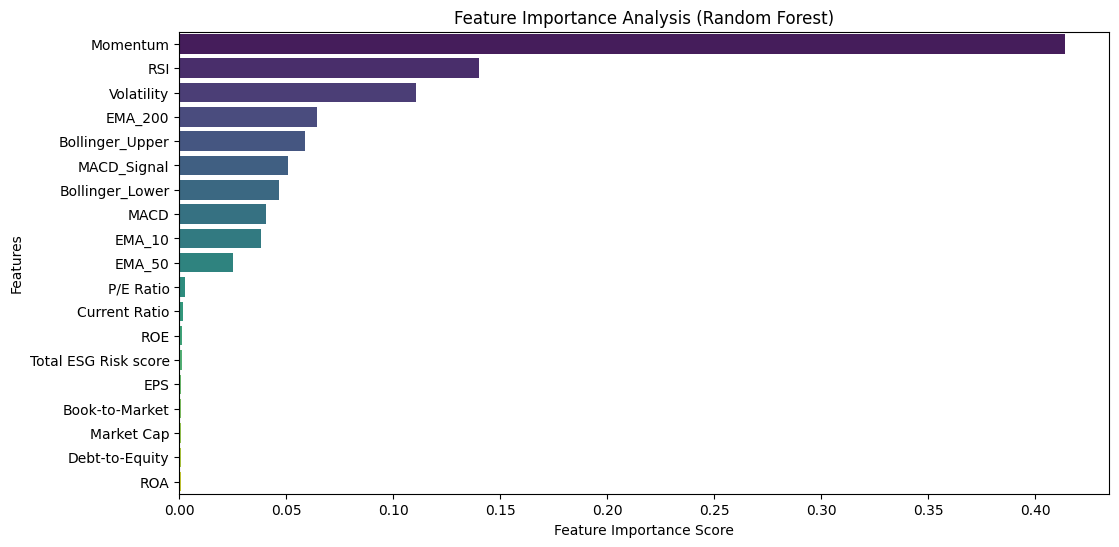

In [50]:
# Extract feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

# Sort in descending order
feature_importance = feature_importance.sort_values(ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (Random Forest)")
plt.show()

### Now let's compare the Neural Network & Random Forest models against benchmark models like Linear Regression and Gradient Boosting to see how well your models perform

### Train Benchmark Models

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
Y_pred_lr = lr_model.predict(X_test)

# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, Y_train)
Y_pred_gb = gb_model.predict(X_test)

### Evaluate All Models

In [52]:
# Import evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

# Calculate scores
models = {
    "Linear Regression": (Y_test, Y_pred_lr),
    "Gradient Boosting": (Y_test, Y_pred_gb),
    "Random Forest": (Y_test, Y_pred_rf),
    "Neural Network": (Y_test, Y_pred_nn)
}

# Print R² Score & MSE for each model
for model_name, (y_true, y_pred) in models.items():
    print(f"{model_name} R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"{model_name} MSE: {mean_squared_error(y_true, y_pred):.6f}")
    print("-" * 40)

Linear Regression R² Score: 0.5866
Linear Regression MSE: 0.001540
----------------------------------------
Gradient Boosting R² Score: 0.5543
Gradient Boosting MSE: 0.001660
----------------------------------------
Random Forest R² Score: 0.6343
Random Forest MSE: 0.001363
----------------------------------------
Neural Network R² Score: 0.6172
Neural Network MSE: 0.001426
----------------------------------------


### Compare Performance Visually

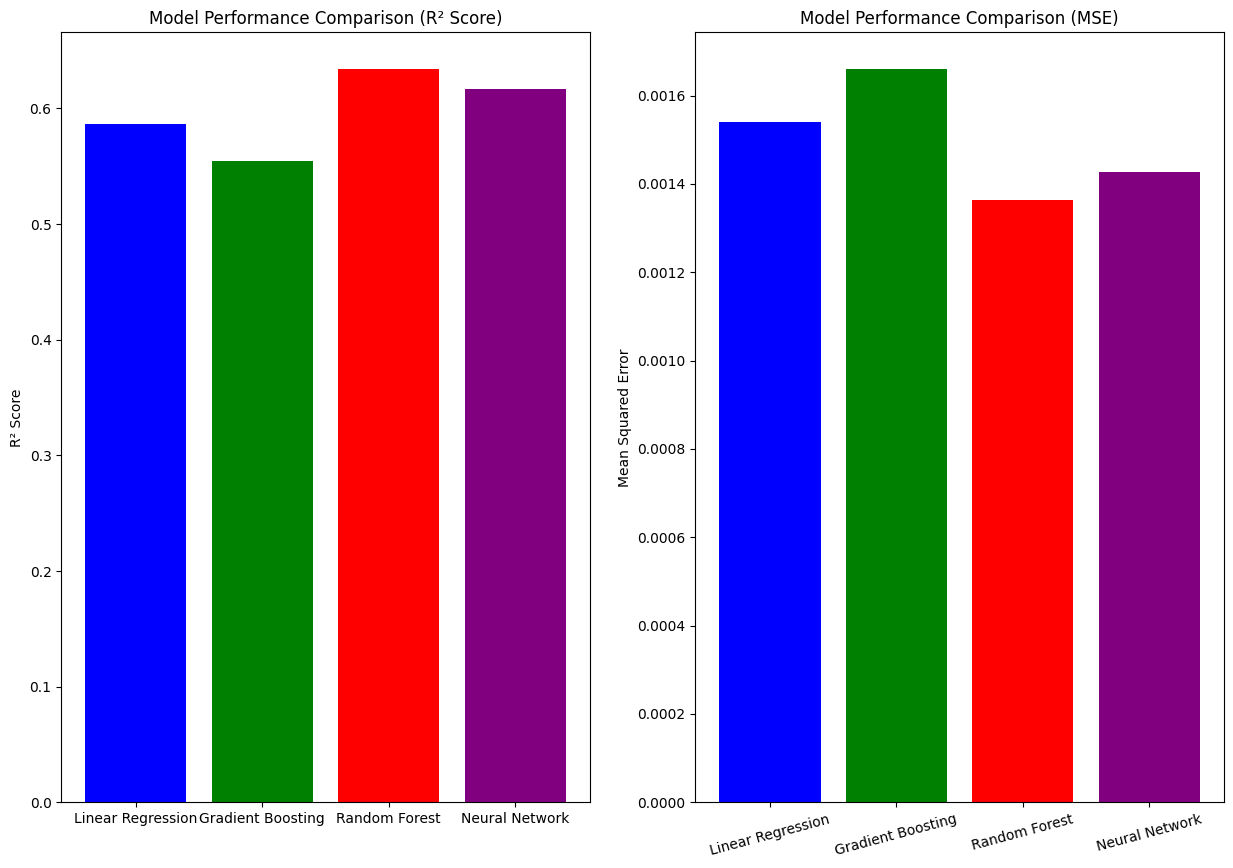

In [53]:
# Create bar plots for comparison
r2_scores = {name: r2_score(y_true, y_pred) for name, (y_true, y_pred) in models.items()}
mse_scores = {name: mean_squared_error(y_true, y_pred) for name, (y_true, y_pred) in models.items()}

plt.figure(figsize=(15, 10))

# R² Score comparison
plt.subplot(1, 2, 1)
plt.bar(r2_scores.keys(), r2_scores.values(), color=['blue', 'green', 'red', 'purple'])
plt.ylabel("R² Score")
plt.title("Model Performance Comparison (R² Score)")

# MSE comparison
plt.subplot(1, 2, 2)
plt.bar(mse_scores.keys(), mse_scores.values(), color=['blue', 'green', 'red', 'purple'])
plt.ylabel("Mean Squared Error")
plt.title("Model Performance Comparison (MSE)")

plt.xticks(rotation=15)
plt.show()

## Perform the Visualize Predictions vs. Actual Returns

### Scatter Plot (Predicted vs. Actual)
This will show how close the predicted returns are to actual returns.

🔹 Red dashed line represents the ideal case where predicted = actual.

🔹 If points align closely with the line, the model is performing well.

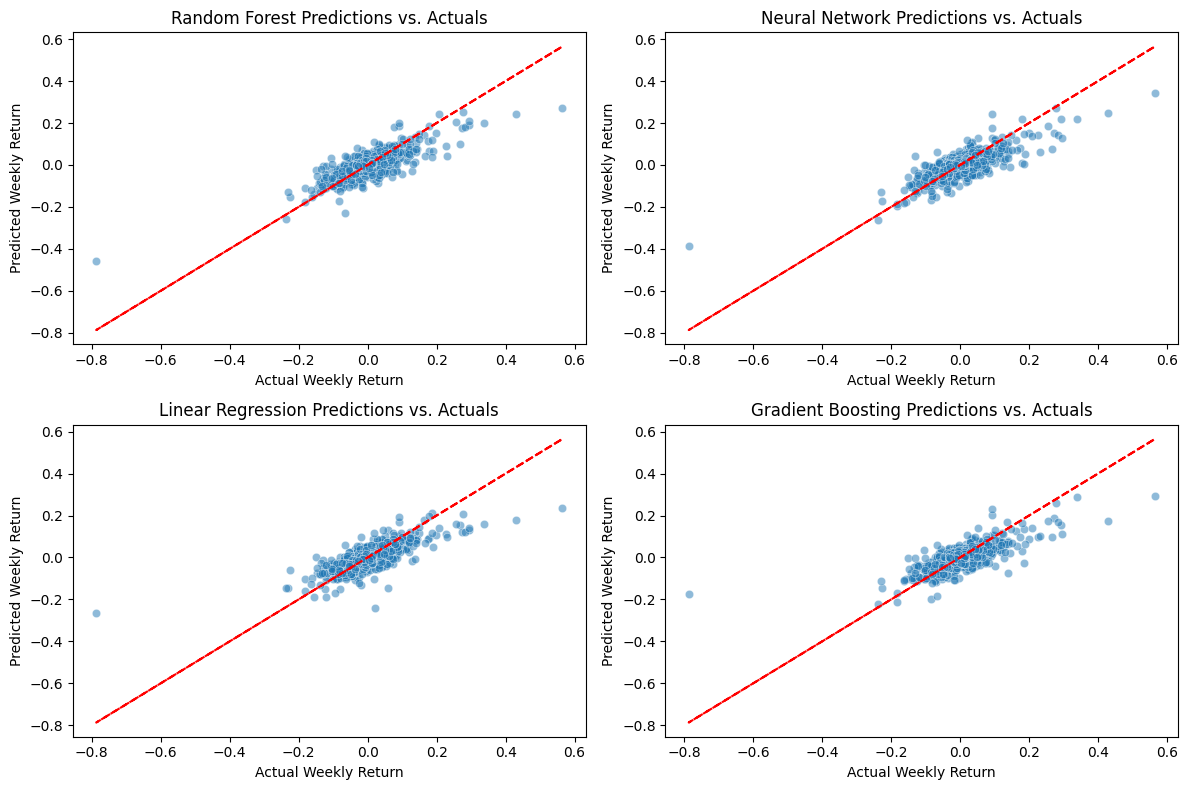

In [54]:
# Define models for visualization
model_predictions = {
    "Random Forest": Y_pred_rf,
    "Neural Network": Y_pred_nn,
    "Linear Regression": Y_pred_lr,
    "Gradient Boosting": Y_pred_gb
}

plt.figure(figsize=(12, 8))

for i, (model, Y_pred) in enumerate(model_predictions.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=Y_test, y=Y_pred, alpha=0.5)
    plt.plot(Y_test, Y_test, color='red', linestyle='dashed')  # Ideal line
    plt.xlabel("Actual Weekly Return")
    plt.ylabel("Predicted Weekly Return")
    plt.title(f"{model} Predictions vs. Actuals")

plt.tight_layout()
plt.show()

### Line Plot (Time-Series View)
This will compare how the predicted returns track the actual returns over time.

🔹 If predicted lines closely follow the actual returns, the model is making accurate forecasts.

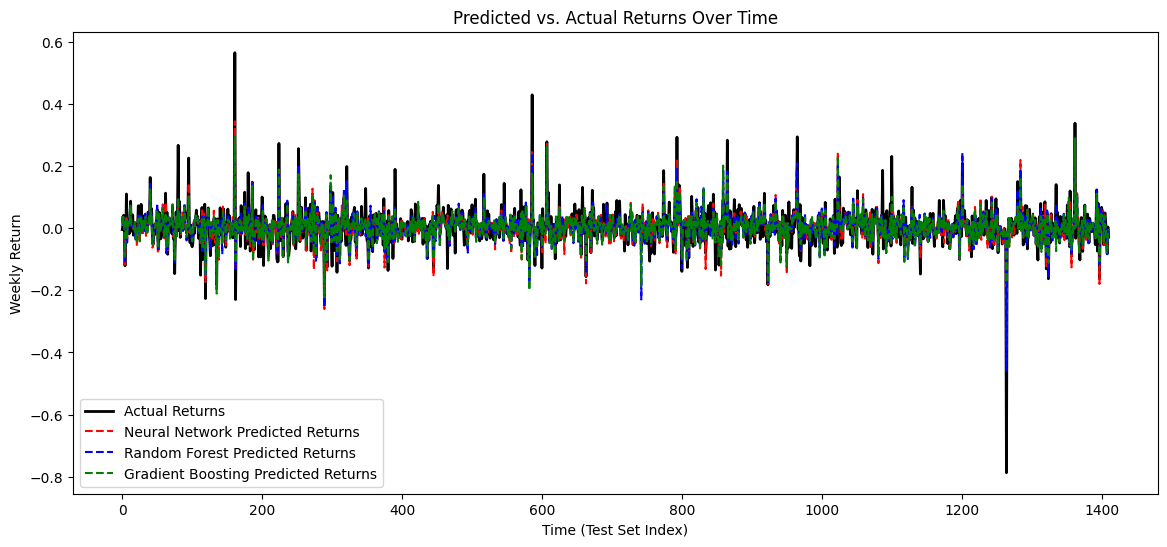

In [55]:
plt.figure(figsize=(14, 6))

# Plot actual vs. predicted returns for Neural Network
plt.plot(Y_test.values, label="Actual Returns", color='black', linewidth=2)
plt.plot(Y_pred_nn, label="Neural Network Predicted Returns", linestyle="dashed", color="red")
plt.plot(Y_pred_rf, label="Random Forest Predicted Returns", linestyle="dashed", color="blue")
plt.plot(Y_pred_gb, label="Gradient Boosting Predicted Returns", linestyle="dashed", color="green")

plt.xlabel("Time (Test Set Index)")
plt.ylabel("Weekly Return")
plt.title("Predicted vs. Actual Returns Over Time")
plt.legend()
plt.show()

### Histogram of Prediction Errors

This shows how far predictions deviate from actual returns.

🔹 A narrow, centered distribution around 0 means fewer prediction errors and a better model.

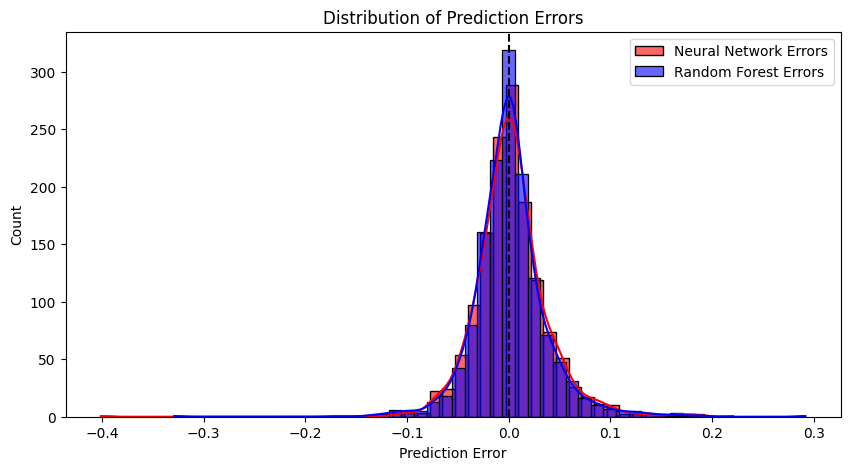

In [56]:
errors_nn = Y_test - Y_pred_nn
errors_rf = Y_test - Y_pred_rf

plt.figure(figsize=(10, 5))
sns.histplot(errors_nn, bins=50, kde=True, color="red", label="Neural Network Errors", alpha=0.6)
sns.histplot(errors_rf, bins=50, kde=True, color="blue", label="Random Forest Errors", alpha=0.6)

plt.axvline(0, color='black', linestyle="dashed")
plt.xlabel("Prediction Error")
plt.title("Distribution of Prediction Errors")
plt.legend()
plt.show()

## Backtest trading strategies using Predicted vs. Actual Returns.

We'll evaluate how well your model performs in a trading strategy by simulating trades based on predicted vs. actual returns.

We'll compare different strategies based on predicted vs. actual returns. Here are some approaches we can test:

1. Buy & Hold Strategy – Invest in the stock and hold it throughout the period.

2. Mean Reversion Strategy – Buy when predicted return is significantly lower than historical average and sell when it's higher.

3. Momentum Strategy – Buy when predicted return is positive and sell when it's negative.

4. Threshold-Based Strategy – Buy only if predicted return is above a certain threshold and sell if below another.

In [57]:
print("Columns in merged_data:", merged_data.columns)

Columns in merged_data: Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Name',
       'Sector', 'Industry', 'Total ESG Risk score', 'Environment Risk Score',
       'Governance Risk Score', 'Social Risk Score', 'Controversy Level',
       'Controversy Score', 'ESG Risk Percentage', 'ESG Risk Level',
       'Daily Return', 'ESG Category', 'PCA1', 'PCA2', 'Log Return',
       'Volatility', 'Momentum', 'Weekly Return', 'Monthly Return', 'ROE',
       'ROA', 'Debt-to-Equity', 'EPS', 'Current Ratio', 'Book-to-Market',
       'Market Cap', 'P/E Ratio', 'RSI', 'MACD', 'MACD_Signal',
       'Bollinger_Upper', 'Bollinger_Lower', 'EMA_10', 'EMA_50', 'EMA_200'],
      dtype='object')


In [58]:
# Create a date range starting from a specific date (e.g., '2020-01-01') assuming daily data
merged_data['Date'] = pd.date_range(start='2020-01-01', periods=len(merged_data), freq='D')

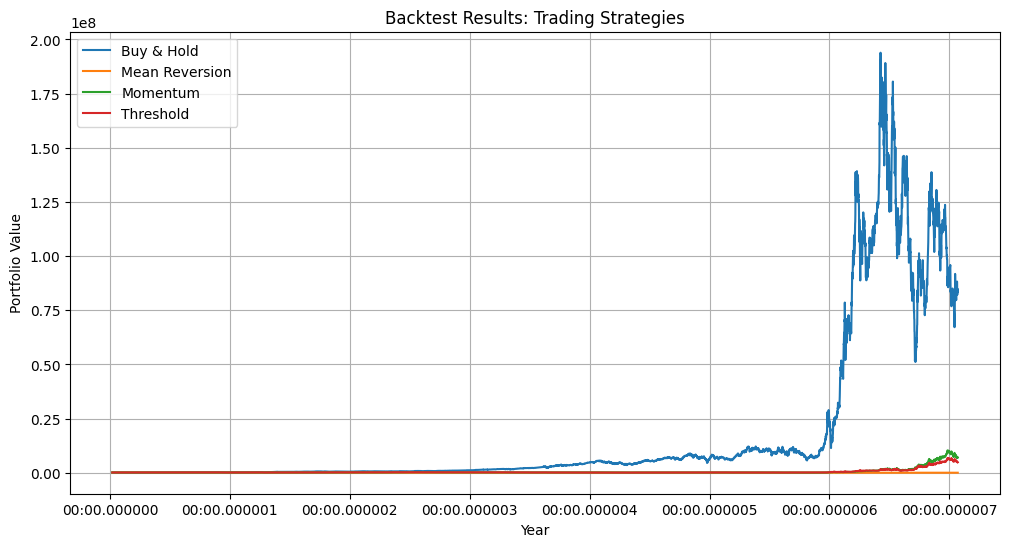

Final Portfolio Value (Buy & Hold): $84,541,070.12
Final Portfolio Value (Mean Reversion): $6.34
Final Portfolio Value (Momentum): $7,020,266.13
Final Portfolio Value (Threshold): $4,830,597.76


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the index is in datetime format
if not isinstance(merged_data.index, pd.DatetimeIndex):
    merged_data.index = pd.to_datetime(merged_data.index)

# Define the required features for standardization
required_features = [
    "Total ESG Risk score", "Momentum", "Volatility", 
    "Market Cap", "P/E Ratio", "ROE", "ROA", "Debt-to-Equity", 
    "EPS", "Current Ratio", "Book-to-Market",
    "Bollinger_Lower", "Bollinger_Upper", "EMA_10", "EMA_50", "EMA_200",
    "RSI", "MACD", "MACD_Signal", "Year"  # Added "Year" as a feature
]

# Ensure only existing columns are used (avoid missing features error)
existing_features = [feature for feature in required_features if feature in merged_data.columns]

# Reorder existing_features to match the order used during scaler fitting
existing_features = [feature for feature in scaler.feature_names_in_ if feature in merged_data.columns]

# Drop rows with NaN values in the selected features
merged_data.dropna(subset=existing_features, inplace=True)

# Check if any features are missing from merged_data compared to the scaler
missing_features = set(scaler.feature_names_in_) - set(merged_data.columns)
if missing_features:
    raise ValueError(f"Missing Features: {missing_features}")

# Transform data using the fitted scaler
X_scaled = scaler.transform(merged_data[existing_features])

# Generate predictions using the trained Neural Network model
try:
    merged_data['Predicted Return'] = nn_model.predict(X_scaled)
except NameError:
    raise ValueError("Neural Network model (nn_model) is not defined or not trained.")

# Define 'Actual Return' if not present
if "Actual Return" not in merged_data.columns:
    merged_data["Actual Return"] = merged_data["Daily Return"]  # Use Daily Return as Actual Return

# Backtesting Function
def backtest(strategy_name, positions):
    capital = 100000  # Initial capital
    positions = pd.Series(positions, index=merged_data.index)
    
    # Shift positions by 1 day (simulate previous day execution)
    returns = positions.shift(1) * merged_data["Actual Return"]
    
    # Replace NaN with 0
    returns.fillna(0, inplace=True)
    
    # Compute cumulative portfolio value
    portfolio_value = (1 + returns).cumprod() * capital
    
    return portfolio_value

# Buy & Hold Strategy (Always Invested)
buy_hold_positions = np.ones(len(merged_data))

# Mean Reversion Strategy
merged_data["Mean Return"] = merged_data["Actual Return"].rolling(window=10, min_periods=1).mean()
mean_reversion_positions = np.where(merged_data["Predicted Return"] < merged_data["Mean Return"], 1, -1)

# Momentum Strategy (Invest if Predicted Return > 0)
momentum_positions = np.where(merged_data["Predicted Return"] > 0, 1, -1)

# Threshold-Based Strategy (Invest if above/below threshold)
threshold_positions = np.where(
    merged_data["Predicted Return"] > 0.01, 1, 
    np.where(merged_data["Predicted Return"] < -0.01, -1, 0)
)

# Backtest Strategies
results = {
    "Buy & Hold": backtest("Buy & Hold", buy_hold_positions),
    "Mean Reversion": backtest("Mean Reversion", mean_reversion_positions),
    "Momentum": backtest("Momentum", momentum_positions),
    "Threshold": backtest("Threshold", threshold_positions)
}

# Plot Results
plt.figure(figsize=(12, 6))
for strategy, portfolio_value in results.items():
    plt.plot(portfolio_value, label=strategy)

plt.legend()
plt.title("Backtest Results: Trading Strategies")
plt.xlabel("Year")  # Updated to show 'Year' instead of full Date
plt.ylabel("Portfolio Value")
plt.grid()
plt.show()

# Print Final Portfolio Values
for strategy, portfolio_value in results.items():
    print(f"Final Portfolio Value ({strategy}): ${portfolio_value.iloc[-1]:,.2f}")

## 📌 Monte Carlo Simulation Approach

1. Generate multiple random scenarios for future stock returns.

2. Simulate portfolio growth over a given time horizon.

3. Analyze risk metrics such as VaR (Value at Risk) and Expected Shortfall.

### 🔍 Explanation:
✅ Simulates 1000 possible portfolio paths for 1 year

✅ Uses historical return mean & volatility to generate scenarios

✅ Plots simulated paths to visualize potential outcomes

✅ Calculates Value at Risk (VaR) at a 95% confidence level

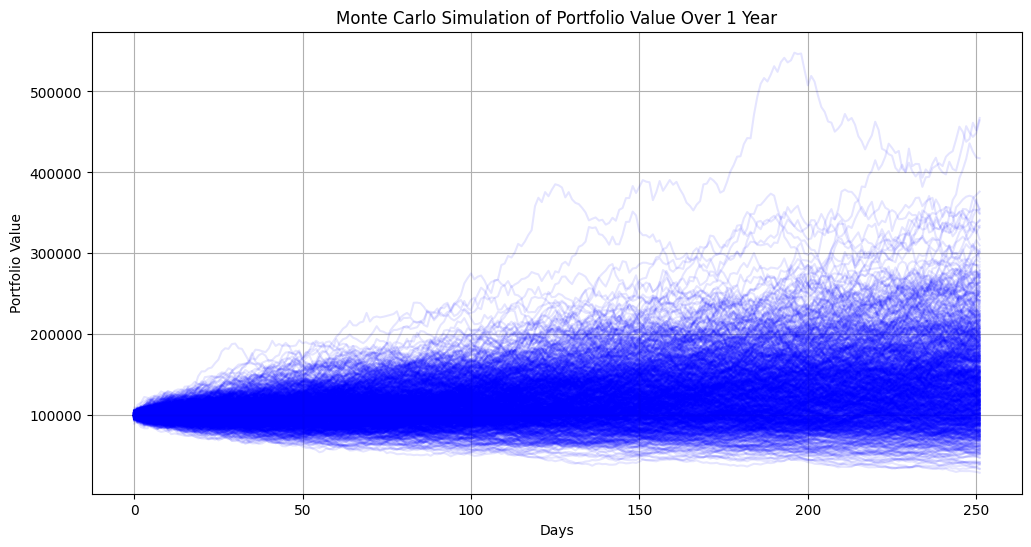

95% Value at Risk (VaR): $30,492.06


In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo parameters
simulations = 1000  # Number of simulated paths
time_horizon = 252  # Number of trading days (1 year)
initial_capital = 100000  # Starting portfolio value

# Extract the daily return distribution from historical data
returns = merged_data['Actual Return'].dropna()
mean_return = np.mean(returns)
std_dev = np.std(returns)

# Monte Carlo Simulation
simulated_portfolios = np.zeros((simulations, time_horizon))

for i in range(simulations):
    simulated_returns = np.random.normal(mean_return, std_dev, time_horizon)
    simulated_portfolios[i] = initial_capital * np.cumprod(1 + simulated_returns)

# Plot Monte Carlo Simulations
plt.figure(figsize=(12, 6))
plt.plot(simulated_portfolios.T, color='blue', alpha=0.1)
plt.title("Monte Carlo Simulation of Portfolio Value Over 1 Year")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid()
plt.show()

# Compute Value at Risk (VaR) at 95% confidence level
var_95 = np.percentile(simulated_portfolios[:, -1], 5)
expected_loss = initial_capital - var_95

print(f"95% Value at Risk (VaR): ${expected_loss:,.2f}")